In [1]:
import argparse
import os
import glob
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt 
from PIL import Image
import json
from pycococreatortools import pycococreatortools

from datetime import datetime

labels = ['chair', 'cushion', 'door', 'indoor-plant', 'sofa', 'table']
# labels = ['chair']
semantic_json_root = '/checkpoint/apratik/ActiveVision/active_vision/info_semantic'

def load_semantic_json(scene):
    replica_root = '/datasets01/replica/061819/18_scenes'
    habitat_semantic_json = os.path.join(replica_root, scene, 'habitat', 'info_semantic.json')
#         habitat_semantic_json = os.path.join(self.sjr, scene + '_info_semantic.json')
#         print(f"Using habitat semantic json {habitat_semantic_json}")
    with open(habitat_semantic_json, "r") as f:
        hsd = json.load(f)
    if hsd is None:
        print("Semantic json not found!")
    return hsd

hsd = load_semantic_json('apartment_0')
label_id_dict = {}
new_old_id = {}
idc = 1
for obj_cls in hsd["classes"]:
    if obj_cls["name"] in labels:
        label_id_dict[obj_cls["id"]] = obj_cls["name"]
        new_old_id[obj_cls['id']] = idc
        idc += 1
        
class PickGoodCandidates:
    def __init__(self, root_dir, active):
        self.imgdir = os.path.join(root_dir, 'rgb')
        self.depthdir = os.path.join(root_dir, 'depth')
        self.segdir = os.path.join(root_dir, 'seg')
        
        num_imgs = len(os.listdir(self.imgdir))
        
        self.is_good = np.zeros(num_imgs+1)
        self.area = np.zeros(num_imgs+1)
        self.is_active = np.zeros(num_imgs+1)
        
        if active:
            with open(os.path.join(root_dir, 'active_frames.txt'), 'r') as f:
                active_frames = f.readlines()
                active_frames = [int(x.strip()) for x in active_frames]
                for x in active_frames:
                    if x < len(self.is_active):
                        self.is_active[x] = True
        
        self.filtered = False
        self.active = active
        self.chosen = set()
        
    def is_open_contour(self, c):
        # check for a bunch of edge points
        # c is of the format num_points * 1 * 2
        edge_points = []
        for x in c:
            if x[0][0] == 0 or x[0][1] == 0 or x[0][0] == 511 or x[0][1] == 511:
                edge_points.append(x)
#         print(len(edge_points))
        if len(edge_points) > 0:
            return True
        return False

    def find_nearest(self, x):
        dist = 10000
        res = -1
        for y, _ in self.good_candidates:
            if abs(x-y) < dist:
                dist = abs(x-y)
                res = y
        # now look in vicinity of res for frame with max size 
        return res
    
    def sample_uniform_nn(self, n):
        if not self.filtered:
            self.filter_candidates()
            
        num_imgs = len(glob.glob(self.imgdir + '/*.jpg'))
        print(f'num_imgs {num_imgs}')
        delta = int(num_imgs / n)
        cand = [delta*x for x in range(1,n+1)]
        return [self.find_nearest(x) for x in cand]
    
    def find_nearest2(self, x):
        dist = 100000
        res = -1
        
        # look in the eps neighborhood of x 
        # find the closest good + active candidate
        # find the closest good candidate
        eps = 0
        while True:
            left = x - eps
            if left >= 0 and self.is_good[left] and self.is_active[left] and left not in self.chosen:
                res = left
                break
            right = x + eps
            if right < len(self.is_good) and self.is_good[right] and self.is_active[right] and right not in self.chosen:
                res = right
                break
            eps += 1
            if left < 0 and right >= len(self.is_good):
                break
        
        if res == -1:
            eps = 0
            while True:
                left = x - eps
                if left >= 0 and self.is_good[left] and left not in self.chosen:
                    res = left
                    break
                right = x + eps
                if right < len(self.is_good) and self.is_good[right] and right not in self.chosen:
                    res = right
                    break
                eps += 1
                if left < 0 and right >= len(self.is_good):
                    break

        for x in range(10):
            self.chosen.add(res+x)
            self.chosen.add(res-x)
        return res
    
    def sample_uniform_nn2(self, n):
        self.chosen = set()
        if not self.filtered:
            self.filter_candidates()
            
        num_imgs = len(glob.glob(self.imgdir + '/*.jpg'))
        print(f'num_imgs {num_imgs}')
        delta = int(num_imgs / n)
        cand = [delta*x for x in range(1,n+1)]
        return [self.find_nearest2(x) for x in cand]
        
    def sample_n(self, n):
        if not self.filtered:
            self.filter_candidates()
            
        # uniformly sample 
        # randomly sample 
        return [x[0] for x in random.sample(self.good_candidates, n)]
    
    def filter_candidates(self):
        for x in range(len(os.listdir(self.imgdir)) + 1):
            if x % 100 == 0:
                print(x)
            is_good, area = self.is_good_candidate(x)
            self.is_good[x] = is_good
            self.area[x] = area
        self.filtered = True
            
    def visualize_good_bad(self, num):
        # TODO: sample num numbers from all, then look at he 
        # sample num from good bad
        good = random.sample(self.good_candidates, num)
        bad = random.sample(self.bad_candidates, num)
        
        for x in range(num):
            gim = os.path.join(self.imgdir, "{:05d}.jpg".format(good[x][0]))
            gim = cv2.cvtColor(cv2.imread(gim), cv2.COLOR_BGR2RGB)
            
            bim = os.path.join(self.imgdir, "{:05d}.jpg".format(bad[x]))
            bim = cv2.cvtColor(cv2.imread(bim), cv2.COLOR_BGR2RGB)
            
            arr = [gim, bim]
            titles = ['good', 'bad']
            plt.figure(figsize=(5,4))
            for i, data in enumerate(arr):
                ax = plt.subplot(1, 2, i+1)
                ax.axis('off')
                ax.set_title(titles[i])
                plt.imshow(data)
            plt.show()
        
    def is_good_candidate(self, x, vis=False):
        segpath = os.path.join(self.segdir, "{:05d}.npy".format(x))
        
        # Load Image
        if not os.path.isfile(segpath):
            return False, 0
        
#         img = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
#         print(img.shape)
        
        # Load Annotations 
        annot = np.load(segpath).astype(np.uint32)
        count = 0
        all_binary_mask = np.zeros_like(annot)
#         print(f'{annot.shape, all_binary_mask.shape}')

        total_area = 0
        total_objects = 0
        
        for i in np.sort(np.unique(annot.reshape(-1), axis=0)):
            try:
                if hsd["id_to_label"][i] < 1 or label_id_dict[hsd["id_to_label"][i]] not in labels:# or hsd["id_to_label"][i] not in self.label_id_dict:
                    continue
                category_info = {"id": new_old_id[hsd["id_to_label"][i]], "is_crowd": False}
    #                     print(f'category_info {category_info}')
            except Exception as ex:
#                 print(ex)
                continue

            binary_mask = (annot == i).astype(np.uint32)
            all_binary_mask = np.bitwise_or(binary_mask, all_binary_mask)
#             plt.imshow(binary_mask, alpha=0.5)

            annotation_info = pycococreatortools.create_annotation_info(
                count, 1, category_info, binary_mask, annot.shape, tolerance=2
            )
#             print(annotation_info)
            if annotation_info and 'area' in annotation_info.keys():
                total_area = annotation_info['area']
                total_objects += 1
#             count+=1
    
        avg_area = total_area/total_objects if total_objects > 0 else 0
        
        if vis:
            plt.imshow(all_binary_mask)
            plt.show()
#             print(np.unique(all_binary_mask))
        
        area = all_binary_mask.sum()
            
        if not all_binary_mask.any():
#             print(f'no masks')
            return False, 0
        
        # Check that all masks are within a certain distance from the boundary
        # all pixels [:10,:], [:,:10], [-10:], [:-10] must be 0:
        if all_binary_mask[:10,:].any() or all_binary_mask[:,:10].any() or all_binary_mask[:,-10:].any() or all_binary_mask[-10:,:].any():
            return False, area
        
        if (all_binary_mask == 1).sum() < 5000:
            return False, area
        
        return True, area
        
    def vis(self, x, contours=None):
        
        imgpath = os.path.join(self.imgdir, "{:05d}.jpg".format(x))
        image = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
        
        if contours:
            image = cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
      
        arr = [image]
        titles = ["{:05d}.jpg".format(x)]
        plt.figure(figsize=(5,4))
        for i, data in enumerate(arr):
    #         print(f'data.shape {data.shape}')
            ax = plt.subplot(1, 1, i+1)
            ax.axis('off')
            ax.set_title(titles[i])
            plt.imshow(data)
        plt.show()

In [2]:
act_data_dir = '/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1636839314_sampled20_1115/1/default'
def_data_dir = '/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200_combined_2_sampled20_1115_nodownsamplingbaseline/1'

og_act_dir = '/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1636839314/1/default'

def get_candidates(data_dir, active):

    s = PickGoodCandidates(data_dir, active=active)

    for gt in [5, 10, 15, 20, 25]:
    #     xs = s.sample_uniform_nn(gt)
        # pick gt frames for each instance 
        x2 = s.sample_uniform_nn2(gt)
        print(x2)
        for x in x2:
    #         print(x)
            s.vis(x)
        
get_candidates(def_data_dir, active=False)

0
num_imgs 1
[-1, -1, -1, -1, -1]


/private/home/apratik/.conda/envs/locobot_env/lib/python3.7/site-packages/pycococreatortools/pycococreatortools.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours = np.subtract(contours, 1)


error: OpenCV(4.5.2) /tmp/pip-req-build-gvmai4nm/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
num_imgs 1212
[294, 485, 726, 966, 1204]


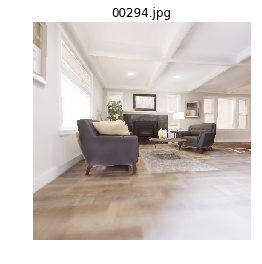

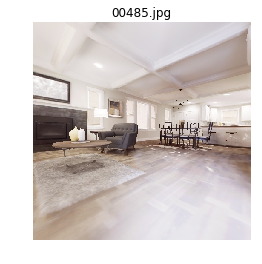

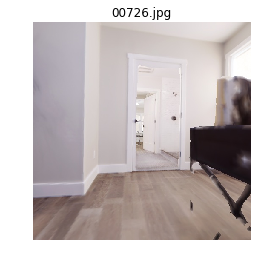

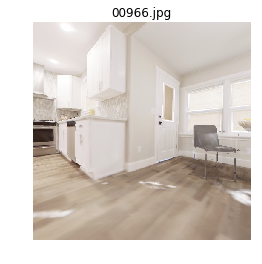

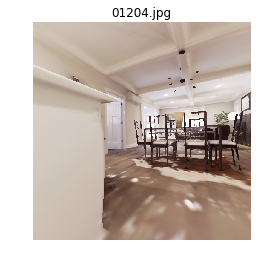

num_imgs 1212
[294, 320, 458, 485, 641, 726, 804, 966, 1184, 1204]


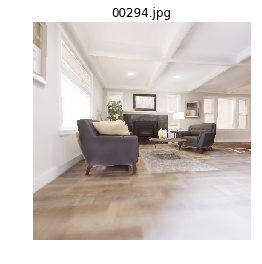

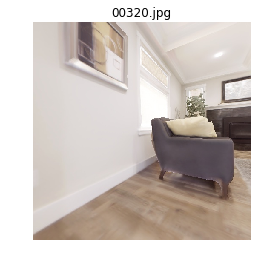

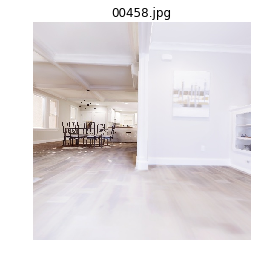

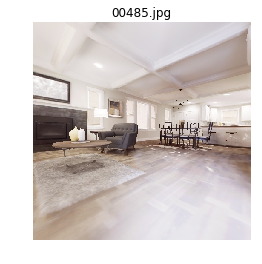

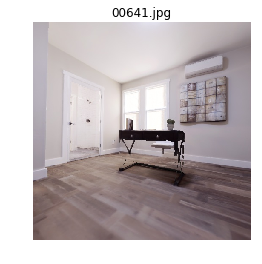

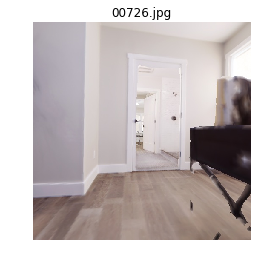

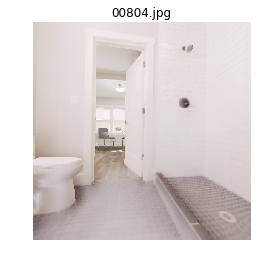

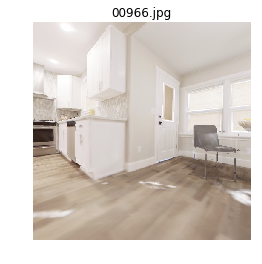

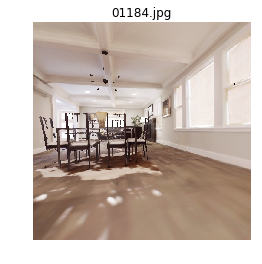

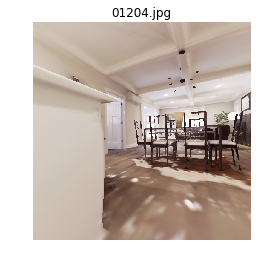

num_imgs 1212
[294, 320, 458, 474, 485, 514, 552, 641, 720, 802, 922, 965, 978, 1184, 1200]


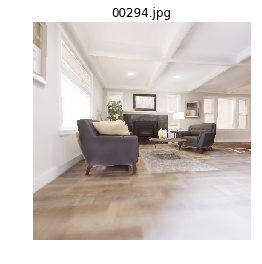

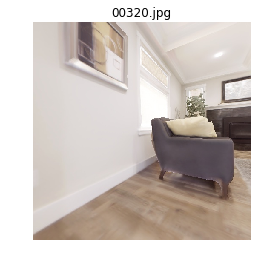

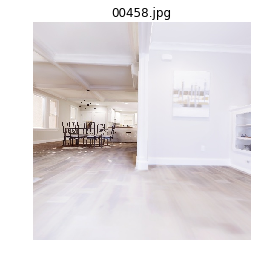

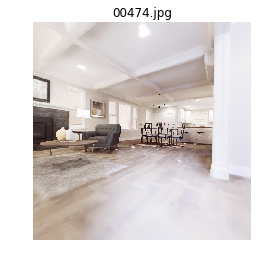

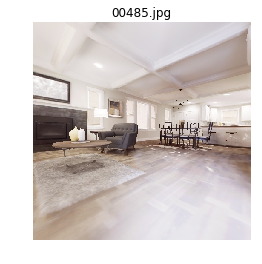

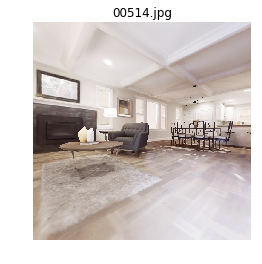

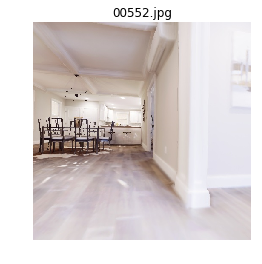

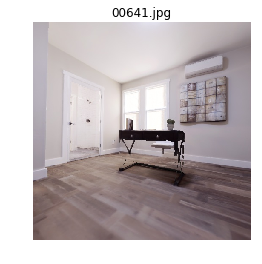

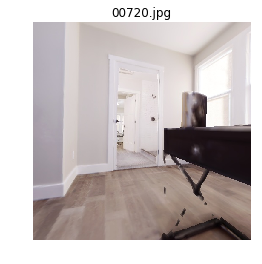

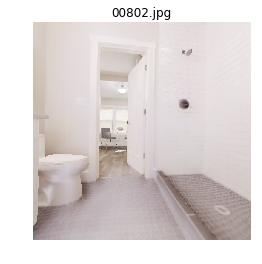

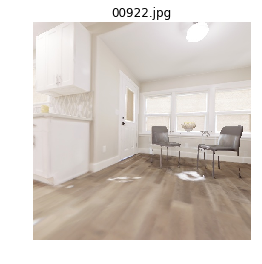

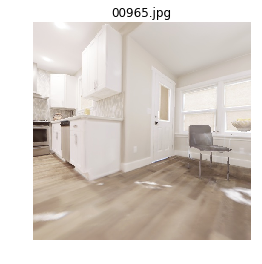

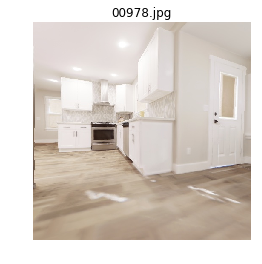

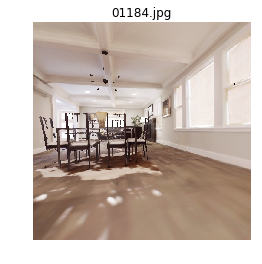

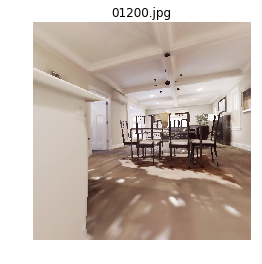

num_imgs 1212
[294, 320, 458, 474, 485, 514, 542, 552, 641, 682, 692, 720, 802, 922, 952, 965, 978, 1184, 1194, 1204]


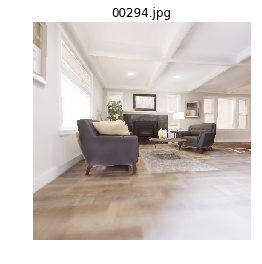

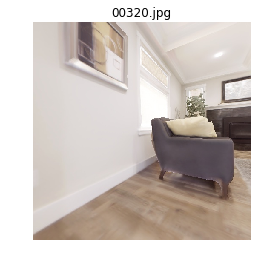

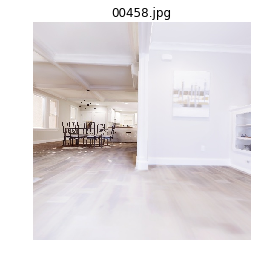

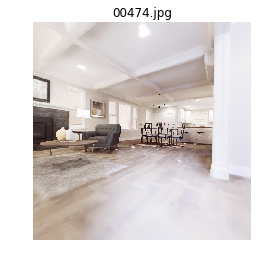

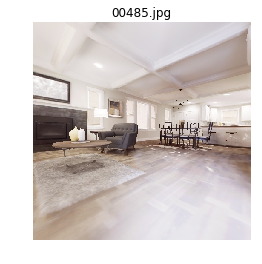

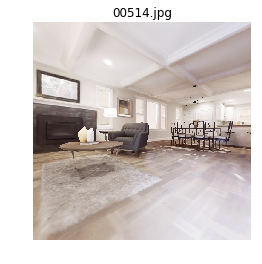

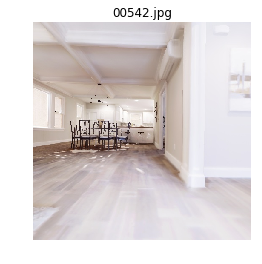

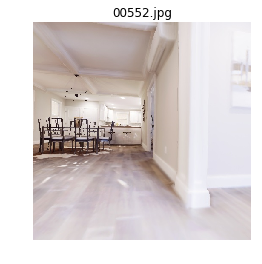

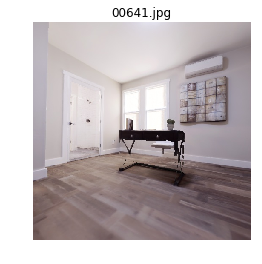

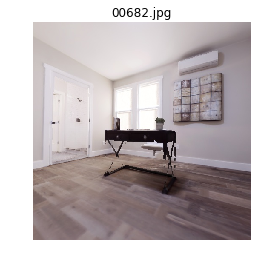

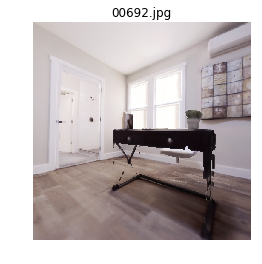

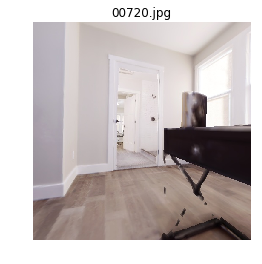

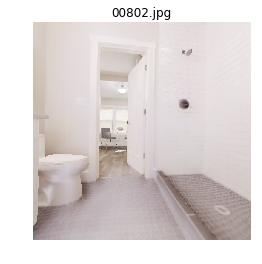

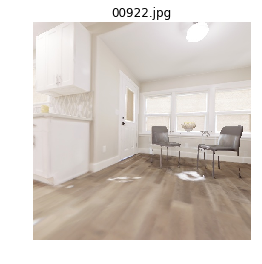

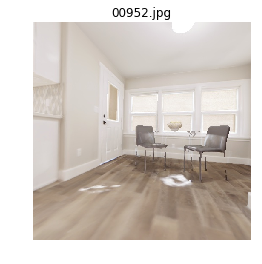

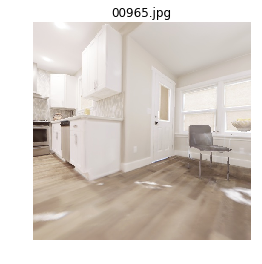

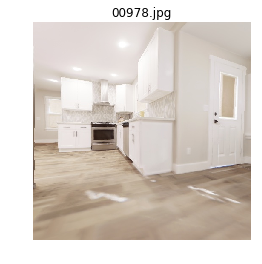

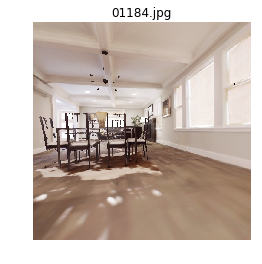

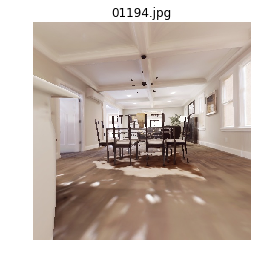

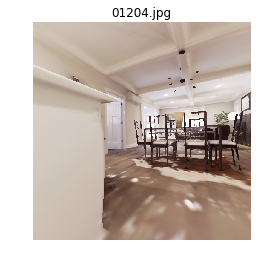

num_imgs 1212
[294, 320, 458, 474, 485, 514, 542, 552, 641, 682, 692, 705, 715, 725, 802, 922, 952, 965, 976, 1184, 1194, 1204, -1, -1, -1]


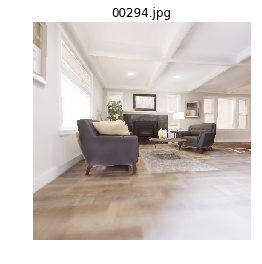

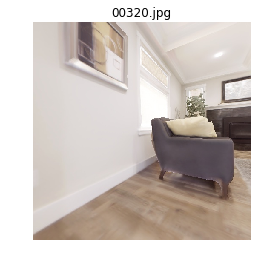

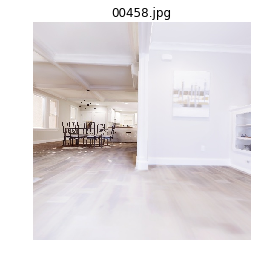

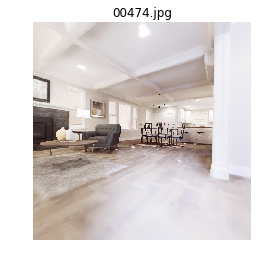

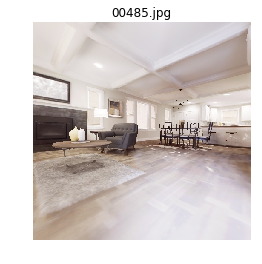

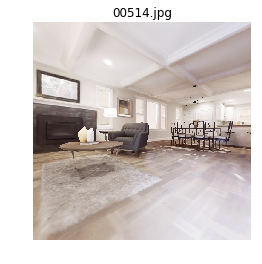

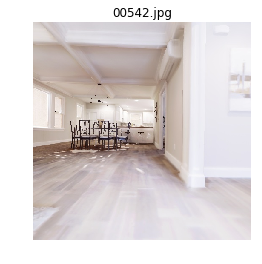

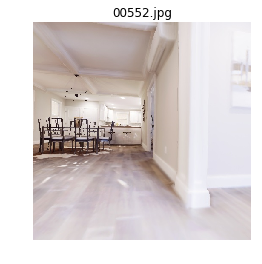

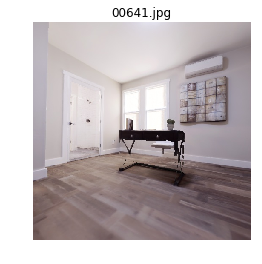

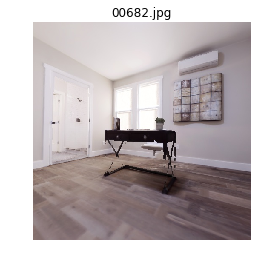

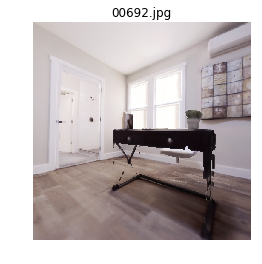

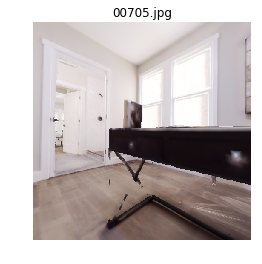

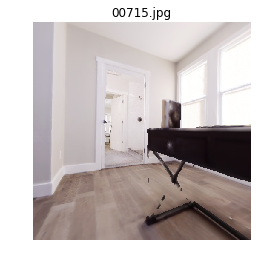

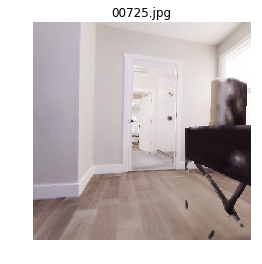

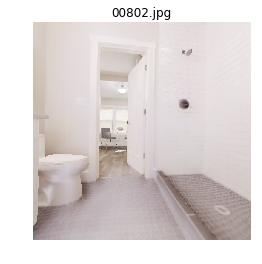

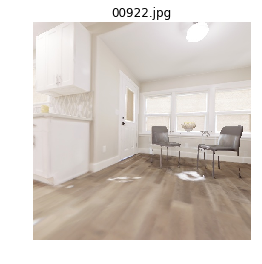

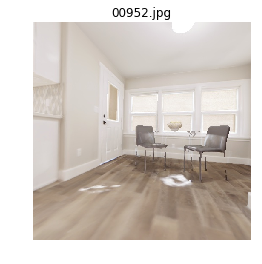

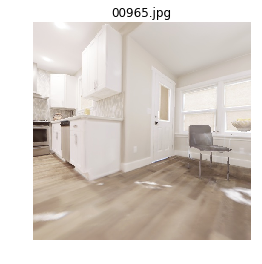

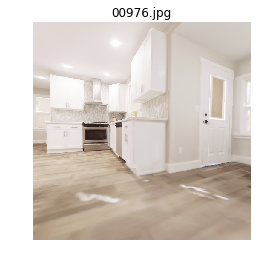

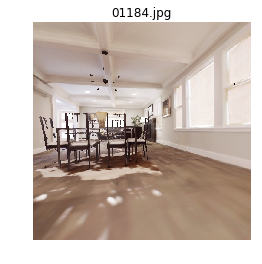

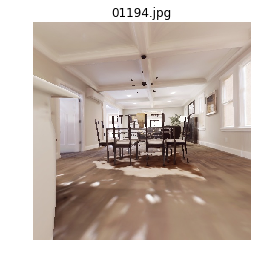

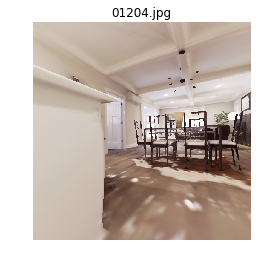

error: OpenCV(4.5.2) /tmp/pip-req-build-gvmai4nm/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [60]:
get_candidates(def_data_dir, active=False)

In [30]:
og_act_dir = '/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1636839314/1/default'


def basic_stats(f):
    elens = []
    cur_len = 1
    for i in range(1, len(f)):
        if f[i] != f[i-1] + 1:
            elens.append(cur_len)
            cur_len = 1
        else:
            cur_len += 1
            
    print(np.average(elens), len(elens))
    

with open(os.path.join(og_act_dir, 'active_frames.txt'), 'r') as f:
    active_frames = f.readlines()
    active_frames = [int(x.strip()) for x in active_frames]
#     print(active_frames)
    
    basic_stats(active_frames)
    
    # pick the median of the active frames that maximizes the labels we care about? is this unfair to the baseline? yes if 
    # we are assuming we have GT (which we said was okay). so no? 
    # should do it the same way for both baseline and active 

25.307692307692307 13
